# EMG Classification Notebook

In this notebook we explore the sEMG dataset for different hand gestures. We perform the following steps:

* Preprocess and clean up our dataset
* Leverage signal processing and exponential smoothing to smooth out the dataset
* Perform a variety of classification techniques


## Contents

* Data Cleaning
* Data Preprocessing
* Data Transformation
* Classification Models

In [15]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io
import scipy
from scipy import signal

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture as GMM
from sklearn import preprocessing

## Building the Dataframe

The study was performed on 8 different individuals (5 male and 3 female). Each individual would perform all six of the different "grips" 30 times each. There are two sensors placed on the forearms of the subjects labeled as "ch1" and "ch2" respectively.

In [2]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

For building the dataframe, each individual sensor readout will be a feature. The two channels will be combined resultig in a 6000 feature data point. 

In [3]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

        
dataset_ = pd.concat(dfs)

#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset_[dataset_['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)

dataset = pd.concat(new_dfs)
dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)
dataset.head()

df_features = dataset.iloc[:,:6000].copy()
df_labels = dataset.iloc[:, 6001]

## Preprocessing the Data

To process the raw data, there are a few techniques to help clean up the data. Firstly, since this is a signal taking the absolute value is a reasonable way to reduce the variability and nosie in the data. Furthermore, smoothing the curve is also an effective way of reducing noise. The butterworth low pass filter is commonly used for signal processsing but a more general method is exponential smoothing (in this case Holt-Winters). 

In [4]:

#Preprosess
def abs_val_filter(data):
    return abs(data.copy())


def butterworth_low_pass_filter(data, 
                                frequency=500, 
                                lp_filter=5,
                                order=4):

    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')

    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg


def holt_smoothing(data,
                  s_level = 0.5,
                  s_slope = 0.1):
    smoothed = []
    for i in data:
        smoothed.append(Holt(i).fit(smoothing_level=s_level, smoothing_slope=s_slope).fittedvalues[:])
    return np.array(smoothed)

By tuning the smoothing parameters we can visually analyze the smoothed data to determine the ideal parameters.

In [5]:
df_abs = abs_val_filter(df_features)
df_holt = holt_smoothing(df_abs.to_numpy(), s_level = 0.03, s_slope = 0.02)
df_butter = butterworth_low_pass_filter(df_abs.to_numpy(), frequency=5000, lp_filter=25, order=5)

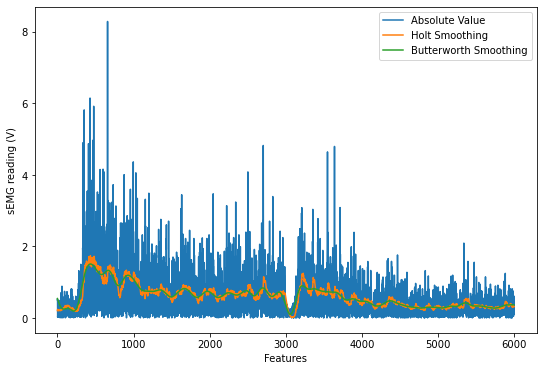

In [6]:
fig = plt.figure(figsize=(9,6))
plt.plot(df_abs.to_numpy()[0], label='Absolute Value')
plt.plot(df_holt[0], label='Holt Smoothing')
plt.plot(df_butter[0], label='Butterworth Smoothing')
plt.legend(loc="upper right")
plt.xlabel("Features")
plt.ylabel("sEMG reading (V)")
plt.show()

At a glance we can see just how noisy the raw data is. The Holt-Winters smoothing does a good job of reducing the noise, whereas the Butterworth filter creates a very smooth curve that matches the Holt-Winters curve very well. We can perform the classification datasets on each of these models, but, in order to reduce the number of models that are being run, we will just move forward with the Holt-Winters smoothed data. 

## Data Transformation

Since we have 6000 features in this data set, it is also a good idea to reduce the dimensionality of the dataset. Also, these methods can help transform the data into a better dataset for classification. Used is the Principle Component Analysis (PCA) and Isomap.

In [7]:
#PCA Transform
n = 20
pca = PCA(n_components=n).fit(df_holt.T)
df_pca = pca.components_.T

#Isomap Transform
iso = Isomap(n_components=n)
df_iso = iso.fit_transform(df_holt)

The below shows plots the first 2 components for both PCA and Isomap with the respective grip images overlayed. 

In [8]:
label_dict = {
    'Spherical':1,
    'Tip':2,
    'Palmar':3,
    'Lateral':4,
    'Cylindrical':5,
    'Hook':6}

col = [label_dict[i] for i in df_labels.to_list()]

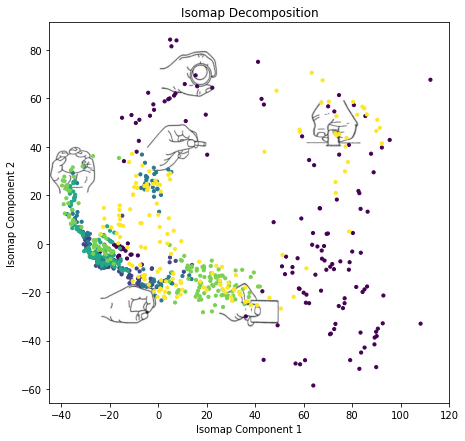

In [9]:
import matplotlib.image as mpimg
img1 = mpimg.imread('./images/cylindrical.png') 
img2 = mpimg.imread('./images/hook.png') 
img3 = mpimg.imread('./images/lateral.png') 
img4 = mpimg.imread('./images/palmar.png') 
img5 = mpimg.imread('./images/spherical.png') 
img6 = mpimg.imread('./images/tip.png') 

fig = plt.figure(figsize=(10,7))
plt.imshow(img1, extent=(0, 25, 60, 80))
plt.imshow(img2, extent=(60, 85, 40, 60))
plt.imshow(img3, extent=(25, 50, -35, -15))
plt.imshow(img4, extent=(-5, 20, 30, 50))
plt.imshow(img5, extent=(-45, -25, 20, 40))
plt.imshow(img6, extent=(-25, 0, -35, -15))

ax = plt.scatter(df_iso[:,0], df_iso[:,1], s=10, c=col)

plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.title("Isomap Decomposition")
plt.show()

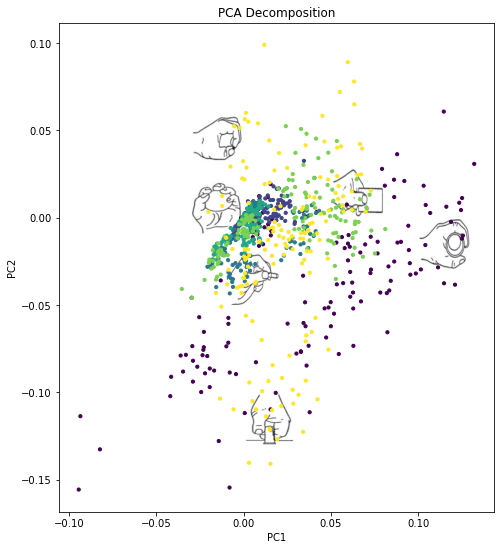

In [10]:
import matplotlib.image as mpimg
img1 = mpimg.imread('./images/cylindrical.png') 
img2 = mpimg.imread('./images/hook.png') 
img3 = mpimg.imread('./images/lateral.png') 
img4 = mpimg.imread('./images/palmar.png') 
img5 = mpimg.imread('./images/spherical.png') 
img6 = mpimg.imread('./images/tip.png') 

fig = plt.figure(figsize=(12,9))
plt.imshow(img1, extent=(0.1, 0.13, -0.03, 0))
plt.imshow(img2, extent=(0, 0.03, -0.13, -0.1))
plt.imshow(img3, extent=(0.05, 0.08, 0.00, 0.03))
plt.imshow(img4, extent=(-0.01, 0.02, -0.05, -0.02))
plt.imshow(img5, extent=(-0.03, 0.0, -0.01, 0.02))
plt.imshow(img6, extent=(-0.03, 0, 0.03, 0.06))

ax = plt.scatter(df_pca[:,0], df_pca[:,1], s=10, c=col)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Decomposition")
plt.show()

We can see there is decent clustering of the hand motions. We will most likely need more compenents. 20 seems like a reasonable number.

## Classification Models

Six classification models were used to classify the data. We found no difference in the PCA and Isomap dataframe accuracies, so for all of the models we used "df_iso" as our final dataset. Here are the classification models used.

* Support Vector Machine 
* Logistic Regression
* Neural Net
* K-Means
* Gaussian Mixture
* Naive-Bayes

All hyper-parameters were tuned through grid search. The following models show the optimal hyperparameters. 

In [21]:
svm_res = []
log_res = []
nn_res = []
nb_res = []
kmeans_res = []
gmm_res = []

le = preprocessing.LabelEncoder()
le.fit(y_train)

for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(df_iso, 
                                                        df_labels, 
                                                        test_size=0.2, 
                                                        random_state=i)

    clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C=10))
    clf_log = make_pipeline(StandardScaler(), LogisticRegression(C=10, max_iter=1000))
    clf_nn = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(200,200,200), max_iter=2000))
    clf_nb = make_pipeline(StandardScaler(), GaussianNB())
    clf_kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=len(LABELS)))
    clf_gmm = make_pipeline(StandardScaler(), GMM(n_components=len(LABELS)))
    
    clfs = [clf_svc, 
            clf_log, 
            clf_nn, 
            clf_nb, 
            clf_kmeans, 
            clf_gmm]
    
    for c in clfs:
        c.fit(X_train, y_train)

    svm_labels = clf_svc.predict(X_test)
    log_labels = clf_log.predict(X_test)
    nn_labels = clf_nn.predict(X_test)
    nb_labels = clf_nb.predict(X_test)
    kmeans_labels = clf_kmeans.predict(X_test)
    gmm_labels = clf_gmm.predict(X_test)

    svm_res.append(((svm_labels == y_test).value_counts()/len(X_test))[1])
    log_res.append(((log_labels == y_test).value_counts()/len(X_test))[1])
    nn_res.append(((nn_labels == y_test).value_counts()/len(X_test))[1])
    nb_res.append(((nb_labels == y_test).value_counts()/len(X_test))[1])
    kmeans_res.append(1 - (sum([abs(i[0] - i[1]) for i in zip(sorted(np.bincount(le.transform(y_test))), 
                                       sorted(np.bincount(kmeans_labels)))])/len(y_test)))
    gmm_res.append(1 - (sum([abs(i[0] - i[1]) for i in zip(sorted(np.bincount(le.transform(y_test))), 
                                       sorted(np.bincount(gmm_labels)))])/len(y_test)))

svm_score = np.max(np.max(np.array(svm_res)))
log_score = np.max(np.max(np.array(log_res)))
nn_score = np.max(np.max(np.array(nn_res)))
nb_score = np.max(np.max(np.array(nb_res)))
kmeans_score = np.max(np.max(np.array(kmeans_res)))
gmm_score = np.max(np.max(np.array(gmm_res)))

In [22]:
print("SVM Accuracy: ", svm_score)
print("LR Accuracy: ", log_score)
print("Neural Network accuracy:", nn_score)
print("Naive Bayes accuracy", nb_score)
print("K-Means accuracy:", kmeans_score)
print("GMM accuracy", gmm_score)

SVM Accuracy:  0.7611111111111111
LR Accuracy:  0.5777777777777777
Neural Network accuracy: 0.7166666666666667
Naive Bayes accuracy 0.55
K-Means accuracy: 0.6222222222222222
GMM accuracy 0.7777777777777778
